In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils
import theano
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import preprocessing
from keras import backend as K
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [6]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
%cd /content/gdrive/My\ Drive/

/content/gdrive/My Drive


In [0]:
# image specification
img_rows,img_cols,img_depth=80,60,9


# Training data

X_tr=[]           # variable to store entire dataset



In [9]:
path = "dataset/kth dataset"
folders = os.listdir(path)
for folder in folders:
  filepath = os.path.join(path, folder)
  files = os.listdir(filepath)
  print(len(files))

100
100
100
100
99
100


In [0]:
path = "dataset/kth dataset"
folders = os.listdir(path)
for folder in folders:
  filepath = os.path.join(path, folder)
  files = os.listdir(filepath)
  for file in files:
    vid = os.path.join(path, folder, file)
    frames1 = []
    frames2 = []
    frames3 = []
    optflow = np.zeros((img_depth-1, img_rows, img_cols, 2))
    optflow_x = np.zeros((img_depth-1, img_rows, img_cols, 2))
    optflow_y = np.zeros((img_depth-1, img_rows, img_cols, 2))
    cap = cv2.VideoCapture(vid)
    fps = cap.get(5)
    # print ("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
    for k in range(img_depth):
        ret, frame = cap.read()
        frame=cv2.resize(frame,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gradient_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
        gradient_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
        if k+1<img_depth:
          optflow[k] = cv2.calcOpticalFlowFarneback(gray[k],gray[k+1], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        
        frames1.append(gray)
        frames2.append(gradient_x)
        frames3.append(gradient_y)
        #plt.imshow(gray, cmap = plt.get_cmap('gray'))
        #plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        #plt.show()
        #cv2.imshow('frame',gray)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    
    optflow_x = cv2.normalize(optflow[...,0], None, 0, 255, cv2.NORM_MINMAX) 
    optflow_x = optflow_x.astype('uint8')  
    optflow_y = cv2.normalize(optflow[...,1], None, 0, 255, cv2.NORM_MINMAX)
    optflow_y = optflow_y.astype('uint8')
    f1=np.array(frames1)
    f2=np.array(frames2)
    f3=np.array(frames3)
    f4=np.array(optflow_x)
    f5=np.array(optflow_y)
    f4=np.reshape(f4,(img_depth-1,img_cols,img_rows))
    f5=np.reshape(f5,(img_depth-1,img_cols,img_rows))

    concat=np.concatenate((f1,f2,f3,f4,f5))
    input=np.array(concat)
    # print (input.shape)
    ipt=np.rollaxis(np.rollaxis(input,2,0),2,0)
    # print (ipt.shape)

    X_tr.append(ipt)

print(len(X_tr))


In [11]:
X_tr_array = np.array(X_tr)
X_tr_array.shape

(599, 60, 80, 43)

In [12]:
X_tr_array = np.array(X_tr)   # convert the frames read into array

num_samples = len(X_tr_array)
print (num_samples)

599


In [0]:
#Assign Label to each class

label=np.ones((num_samples,),dtype = int)
label[0:100]= 0
label[100:200] = 1
label[200:300] = 2
label[300:400] = 3
label[400:499]= 4
label[499:] = 5

In [14]:
X_tr_array=np.reshape(X_tr_array,(599,80,60,43))
X_tr_array.shape

(599, 80, 60, 43)

In [70]:
train_data = [X_tr_array,label]

(X_train, y_train) = (train_data[0],train_data[1])
print('X_Train shape:', X_train.shape)

train_set = np.zeros((num_samples, 1, img_rows,img_cols,43))

for h in range(num_samples):
    train_set[h][0][:][:][:]=X_train[h,:,:,:]
 

patch_size = 43    # img_depth or number of frames used for each video

print(train_set.shape, 'train samples')

# CNN Training parameters

batch_size = 2
nb_classes =6 
nb_epoch =50

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)

'''
# number of convolutional filters to use at each layer
nb_filters = [32, 32]

# level of pooling to perform at each layer (POOL x POOL)
nb_pool = [3, 3]

# level of convolution to perform at each layer (CONV x CONV)
nb_conv = [5,5]
'''
# Pre-processing

train_set = train_set.astype('float32')

train_set -= np.mean(train_set)

train_set /=np.max(train_set)


X_Train shape: (599, 80, 60, 43)
(599, 1, 80, 60, 43) train samples


In [0]:
import tensorflow as tf
import keras
from keras import Input
from keras.models import Model
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.layers.merge import concatenate
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [0]:
import keras.backend.tensorflow_backend as tfback

In [0]:
def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]


In [74]:
tfback._get_available_gpus = _get_available_gpus
tfback._get_available_gpus()

['/device:GPU:0']

In [75]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU'),
 LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [76]:
# Define model

model = Sequential()

model.add(Convolution3D(8, 9, 7, 3,input_shape=(1, img_rows, img_cols, 43), activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 1)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))

model.add(Convolution3D(16, 7, 7, 3,input_shape=(1, img_rows, img_cols, 43), activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3,1)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))

model.add(Convolution3D(32, 6, 4, 1,input_shape=(1, img_rows, img_cols, 43), activation='relu'))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
#model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(nb_classes,init='normal'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(8, (9, 7, 3), input_shape=(1, 80, 60..., activation="relu")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(16, (7, 7, 3), input_shape=(1, 80, 60..., activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, (6, 4, 1), input_shape=(1, 80, 60..., activation="relu")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, kernel_initializer="normal")`


In [0]:
#model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

# Split the data

X_train_new, X_val_new, y_train_new,y_val_new =  train_test_split(train_set, Y_train, test_size=0.2, random_state=4)



In [78]:
hist = model.fit(X_train_new, y_train_new, validation_data=(X_val_new,y_val_new),batch_size=batch_size,nb_epoch = nb_epoch,shuffle=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 479 samples, validate on 120 samples
Epoch 1/50
479/479 [==============================] - 5s 11ms/step - loss: 2.2465 - accuracy: 0.3591 - val_loss: 1.4553 - val_accuracy: 0.4250
Epoch 2/50
479/479 [==============================] - 4s 9ms/step - loss: 1.7541 - accuracy: 0.4301 - val_loss: 1.0279 - val_accuracy: 0.6083
Epoch 3/50
479/479 [==============================] - 4s 9ms/step - loss: 1.5969 - accuracy: 0.4656 - val_loss: 1.1163 - val_accuracy: 0.5667
Epoch 4/50
479/479 [==============================] - 4s 9ms/step - loss: 1.3334 - accuracy: 0.4990 - val_loss: 1.0531 - val_accuracy: 0.5583
Epoch 5/50
479/479 [==============================] - 4s 9ms/step - loss: 1.3816 - accuracy: 0.4906 - val_loss: 0.9538 - val_accuracy: 0.5500
Epoch 6/50
479/479 [==============================] - 4s 9ms/step - loss: 1.0560 - accuracy: 0.5866 - val_loss: 0.9754 - val_accuracy: 0.5667
Epoch 7/50
479/479 [==============================] - 4s 9ms/step - loss: 1.1294 - accuracy: 0.5386 -

120/120 [==============================] - 0s 3ms/step
Test score: 1.537817478478549
Test accuracy: 0.675000011920929
['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


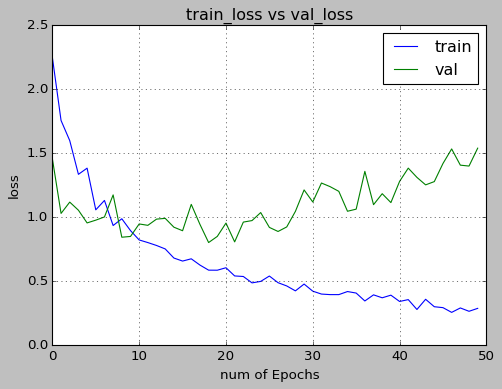

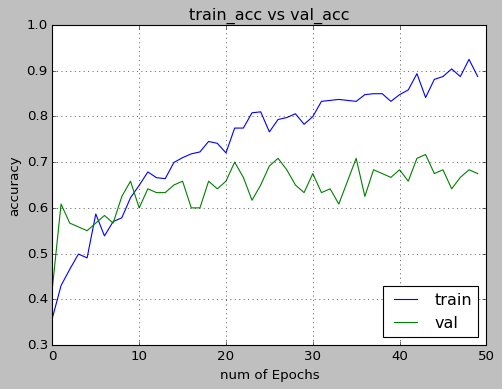

In [79]:



#hist = model.fit(train_set, Y_train, batch_size=batch_size,
#         nb_epoch=nb_epoch,validation_split=0.2, show_accuracy=True,
#           shuffle=True)
#batch_size=32
#nb_epoch=120
 # Evaluate the model
score = model.evaluate(X_val_new, y_val_new, batch_size=batch_size)
print('Test score:', score[0])
print('Test accuracy:', score[1])


# Plot the results
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(nb_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
print (plt.style.available) # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic']) 